In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('../../data/df_6H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (35064, 39)

Number of unique patients: 5844

SepsisLabel class counts:
 SepsisLabel
1.0    17532
0.0    17532
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2922
1.0    2922
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [3]:
# split
train_df, test_df = split_train_test_data_v2(data) 

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

functions_and_imports.ipynb:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - sequences (list): Une liste de tableaux numpy représentant les séquences de caractéristiques.\n",
functions_and_imports.ipynb:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - labels (list): Une liste d'étiquettes associées à chaque séquence.\n",


In [4]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((4675, 6, 35), (4675,), (1169, 6, 35), (1169,))

In [5]:
# Reshape pour ajouter une dimension de canal pour le CNN
X_train = normalize_sequences_train.reshape(-1, 6, 35, 1)
X_val = normalize_sequences_test.reshape(-1, 6, 35, 1)


In [6]:
X_train.shape, X_val.shape

((4675, 6, 35, 1), (1169, 6, 35, 1))

In [13]:

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_and_train_cnn_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
    """
    Construit et entraîne un modèle CNN pour la prédiction de la septicémie à partir de séquences temporelles.

    Args:
    - X_train: Séquences d'entraînement reshaped pour le CNN.
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation reshaped pour le CNN.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (height, width, channels).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle CNN entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [14]:
input_shape = (6, 35, 1)
model_cnn, history_cnn = build_and_train_cnn_model(X_train, labels_train, X_val, labels_test, input_shape)


Epoch 1/300


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5010 - loss: 0.6945 - val_accuracy: 0.4885 - val_loss: 0.6921
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5164 - loss: 0.6918 - val_accuracy: 0.6322 - val_loss: 0.6893
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5241 - loss: 0.6903 - val_accuracy: 0.6544 - val_loss: 0.6871
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5397 - loss: 0.6888 - val_accuracy: 0.5492 - val_loss: 0.6849
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5646 - loss: 0.6863 - val_accuracy: 0.6005 - val_loss: 0.6809
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5946 - loss: 0.6818 - val_accuracy: 0.6920 - val_loss: 0.6751
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5987 - loss: 0.6782 - val_accuracy: 0.7109 - val_loss: 0.6680
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6055 - loss: 0.6739 - val_accuracy: 0.7528 - val_l

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8673 - loss: 0.3056 - val_accuracy: 0.8931 - val_loss: 0.2558
Epoch 52/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8709 - loss: 0.2966 - val_accuracy: 0.8982 - val_loss: 0.2562
Epoch 53/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8873 - loss: 0.2875 - val_accuracy: 0.8888 - val_loss: 0.2538
Epoch 54/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8935 - loss: 0.2752 - val_accuracy: 0.8871 - val_loss: 0.2560
Epoch 55/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8841 - loss: 0.2785 - val_accuracy: 0.8905 - val_loss: 0.2564
Epoch 56/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8872 - loss: 0.2672 - val_accuracy: 0.8905 - val_loss: 0.2533
Epoch 57/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8771 - loss: 0.2818 - val_accuracy: 0.8982 - val_loss: 0.2500
Epoch 58/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8782 - loss: 0.2842 - val_accuracy: 0.8905 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9033 - loss: 0.2368 - val_accuracy: 0.9059 - val_loss: 0.2275
Epoch 102/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9034 - loss: 0.2407 - val_accuracy: 0.8999 - val_loss: 0.2267
Epoch 103/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8907 - loss: 0.2406 - val_accuracy: 0.9025 - val_loss: 0.2264
Epoch 104/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9029 - loss: 0.2364 - val_accuracy: 0.9050 - val_loss: 0.2260
Epoch 105/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9031 - loss: 0.2345 - val_accuracy: 0.9008 - val_loss: 0.2260
Epoch 106/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9020 - loss: 0.2388 - val_accuracy: 0.8999 - val_loss: 0.2249
Epoch 107/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8945 - loss: 0.2479 - val_accuracy: 0.9059 - val_loss: 0.2247
Epoch 108/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9079 - loss: 0.2356 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9187 - loss: 0.2130 - val_accuracy: 0.9136 - val_loss: 0.2122
Epoch 152/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9116 - loss: 0.2077 - val_accuracy: 0.9162 - val_loss: 0.2120
Epoch 153/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9040 - loss: 0.2345 - val_accuracy: 0.9145 - val_loss: 0.2120
Epoch 154/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9135 - loss: 0.2098 - val_accuracy: 0.9076 - val_loss: 0.2210
Epoch 155/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9075 - loss: 0.2239 - val_accuracy: 0.9110 - val_loss: 0.2147
Epoch 156/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9144 - loss: 0.2138 - val_accuracy: 0.9127 - val_loss: 0.2118
Epoch 157/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9094 - loss: 0.2094 - val_accuracy: 0.9170 - val_loss: 0.2127
Epoch 158/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9108 - loss: 0.2283 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9242 - loss: 0.1969 - val_accuracy: 0.9239 - val_loss: 0.2015
Epoch 202/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9222 - loss: 0.1947 - val_accuracy: 0.9187 - val_loss: 0.2016
Epoch 203/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9188 - loss: 0.1994 - val_accuracy: 0.9264 - val_loss: 0.2006
Epoch 204/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9293 - loss: 0.1873 - val_accuracy: 0.9230 - val_loss: 0.2003
Epoch 205/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9247 - loss: 0.1885 - val_accuracy: 0.9187 - val_loss: 0.2023
Epoch 206/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9241 - loss: 0.2009 - val_accuracy: 0.9179 - val_loss: 0.2076
Epoch 207/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9260 - loss: 0.1939 - val_accuracy: 0.9213 - val_loss: 0.2034
Epoch 208/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9347 - loss: 0.1855 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9333 - loss: 0.1662 - val_accuracy: 0.9230 - val_loss: 0.1931
Epoch 252/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9258 - loss: 0.1826 - val_accuracy: 0.9256 - val_loss: 0.1930
Epoch 253/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9337 - loss: 0.1724 - val_accuracy: 0.9230 - val_loss: 0.1927
Epoch 254/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9271 - loss: 0.1857 - val_accuracy: 0.9196 - val_loss: 0.1999
Epoch 255/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9304 - loss: 0.1769 - val_accuracy: 0.9239 - val_loss: 0.1965
Epoch 256/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9261 - loss: 0.1833 - val_accuracy: 0.9222 - val_loss: 0.1975
Epoch 257/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9279 - loss: 0.1836 - val_accuracy: 0.9256 - val_loss: 0.1943
Epoch 258/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9259 - loss: 0.1873 - val_accuracy: 

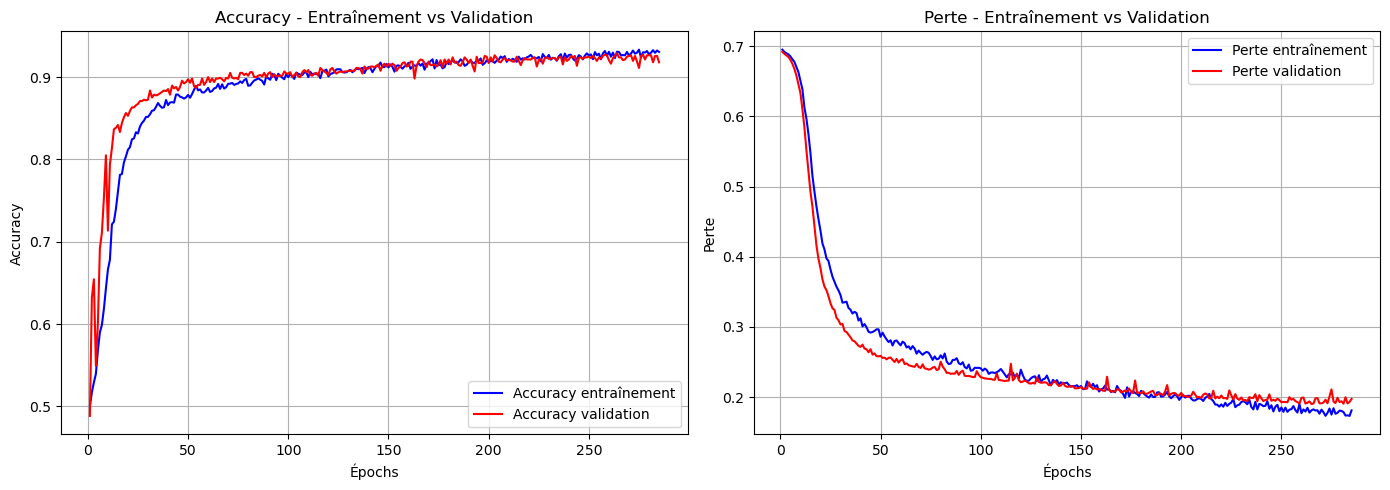

In [15]:
plot_training_history(history_cnn)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9239
Precision: 0.9249
Recall: 0.9264
F1-Score: 0.9256
AUROC: 0.9754


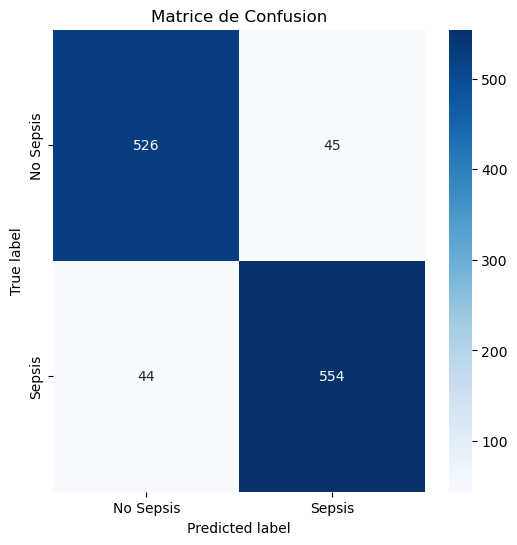

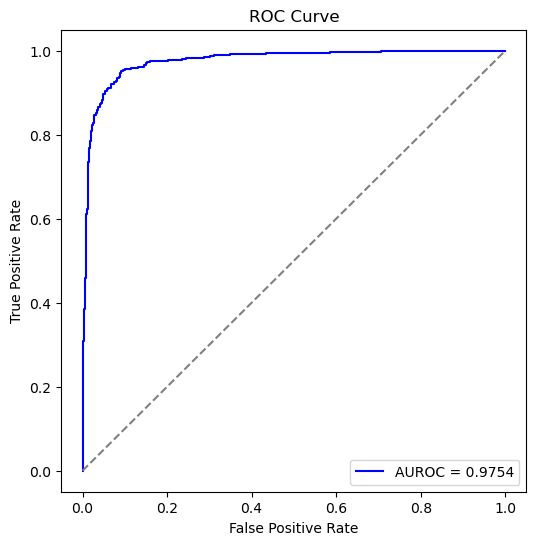

In [16]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_cnn, normalize_sequences_test, labels_test)